## Data Scienist Technical Test - John Ho

### 1. Build a product to identify when the Output Labels (Food, Hot Drinks) are present in a TV Show (e.g. a moment in time where hot drinks were present on the screen, based on the Rekognition confidence scores)

This is a **supervised** machine learning problem for **binary classification**; our model is based on the input features generated by AWS Rekognition's pre-defined objects and confidence score

### A. Exploratory Data Analysis

#### Preliminary
let's load the required libraries

In [1]:
# the basics
import numpy as np
import pandas as pd
import time                     # note: good for clocking computation time between difference models

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Our Data
Data is provided!

The file is a CSV sorted by show_name and time_offset. The most important columns are:
* `show_name` is the name of the television program, for example Fresh Meat or Hollyoaks. Included is one episode for each show.
* `time_offset` is the timestamp, in seconds since the beginning of the episode.
* `r_abies` to `r_zoo` are the Input Features produced by AWS Rekognition, for the screenshot of the video at that `time_offset`.
* `h_alcohol_str` to `h_phone_str` are the Output Labels that you’re trying to predict.

In [10]:
fname = 'data/tv_show_dataset.csv'
data = pd.read_csv( fname, 
                  #index_col = 0
                  )

take a look at the data

In [17]:
data.shape

(16568, 1610)

In [11]:
data.head(10)

,show_name,time_offset,r_abies,r_abyssinian,r_accessories,r_accipiter,r_acorn,r_adapter,r_adorable,r_adventure,...,r_yak,r_yard,r_yew,r_zebra,r_zebra_crossing,r_zoo,h_alcohol_str,h_food_str,h_hot_drink_str,h_phone_str
0,fresh_meat,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.540910,0.0,0.0,0.0,0,0,0,0
1,fresh_meat,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.515789,0.0,0.0,0.0,0,0,0,0
2,fresh_meat,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.527750,0.0,0.0,0.0,0,0,0,0
3,fresh_meat,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.534361,0.0,0.0,0.0,0,0,0,0
4,fresh_meat,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.529979,0.0,0.0,0.0,0,0,0,0
5,fresh_meat,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.000000,0.0,0.0,0.0,0,1,0,0
6,fresh_meat,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.000000,0.0,0.0,0.0,0,1,1,0
7,fresh_meat,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.000000,0.0,0.0,0.0,0,1,1,0
8,fresh_meat,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.000000,0.0,0.0,0.0,0,1,1,0
9,fresh_meat,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.000000,0.0,0.0,0.0,0,1,1,0


In [12]:
data.dtypes

show_name                 object
time_offset                int64
r_abies                  float64
r_abyssinian             float64
r_accessories            float64
r_accipiter              float64
r_acorn                  float64
r_adapter                float64
r_adorable               float64
r_adventure              float64
r_aerial_view            float64
r_affenpinscher          float64
r_afghan_hound           float64
r_african_grey_parrot    float64
r_afro_hairstyle         float64
r_aftershave             float64
r_agaric                 float64
r_agavaceae              float64
r_air_conditioner        float64
r_aircraft               float64
r_airedale               float64
r_airfield               float64
r_airliner               float64
r_airplane               float64
r_airport                float64
r_aisle                  float64
r_alcohol                float64
r_algae                  float64
r_alley                  float64
r_alleyway               float64
          

In [13]:
data.describe()

,time_offset,r_abies,r_abyssinian,r_accessories,r_accipiter,r_acorn,r_adapter,r_adorable,r_adventure,r_aerial_view,...,r_yak,r_yard,r_yew,r_zebra,r_zebra_crossing,r_zoo,h_alcohol_str,h_food_str,h_hot_drink_str,h_phone_str
count,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,...,16568.0,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000,16568.000000
mean,1154.162723,0.000338,0.000063,0.016379,0.000036,0.000032,0.000479,0.002098,0.000050,0.001141,...,0.0,0.001586,0.006647,0.000078,0.000083,0.000105,0.199239,0.088363,0.040983,0.057219
std,769.734098,0.013128,0.005775,0.092024,0.004661,0.004112,0.017332,0.034430,0.006475,0.028809,...,0.0,0.028863,0.061150,0.007127,0.007720,0.007856,0.399441,0.283831,0.198256,0.232267
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,518.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1036.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1724.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2884.000000,0.516965,0.527265,0.837948,0.599949,0.529311,0.847798,0.861480,0.833427,0.971708,...,0.0,0.638517,0.939912,0.663115,0.817520,0.657645,1.000000,1.000000,1.000000,1.000000


#### Check for missing data

Text(176,0.5,'missing data')

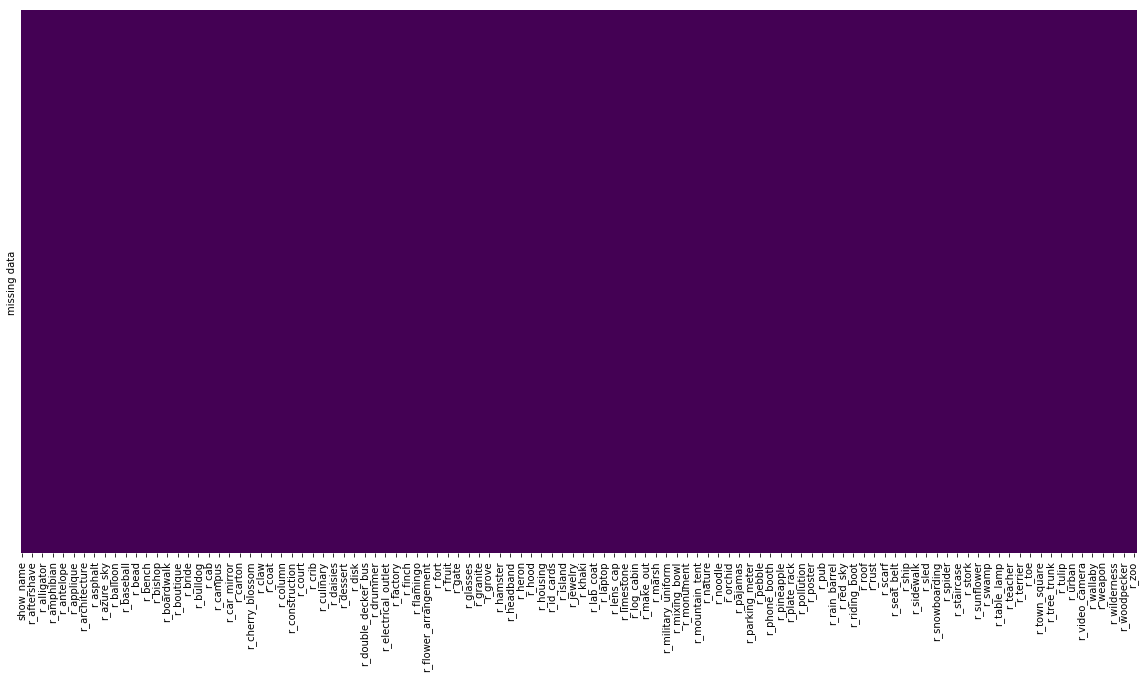

In [14]:
plt.figure(figsize = (20,10))
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.ylabel('missing data')

#### Check for duplicates

In [15]:
data_dup = data[
            data.duplicated( 
                #subset = l_dup_check, 
                keep = False)
            ]
print( f' Found { len ( data_dup )} duplicated records.')

if len(data_dup)> 0:
    data_dup.head(10)

 Found 0 duplicated records.


#### Let's Visualize the Data
* Data points by Different TV Shows
* Observation for each Output Label

In [24]:
print(f'There are {len(data.show_name.unique())} shows.\n\n-----\nData points by shows\n-----')
data_showcount = data.groupby('show_name')['time_offset'].count()
data_showcount

There are 8 shows.

-----
Data points by shows
-----


show_name
fresh_meat             2459
friday_night_dinner    1438
hollyoaks              1400
made_in_chelsea        2884
made_in_chelsea_la     2813
my_mad_fat_diary       2879
peep_show              1384
the_inbetweeners       1311
Name: time_offset, dtype: int64

[Text(0,0,'fresh_meat'),
 Text(0,0,'friday_night_dinner'),
 Text(0,0,'hollyoaks'),
 Text(0,0,'made_in_chelsea'),
 Text(0,0,'made_in_chelsea_la'),
 Text(0,0,'my_mad_fat_diary'),
 Text(0,0,'peep_show'),
 Text(0,0,'the_inbetweeners')]

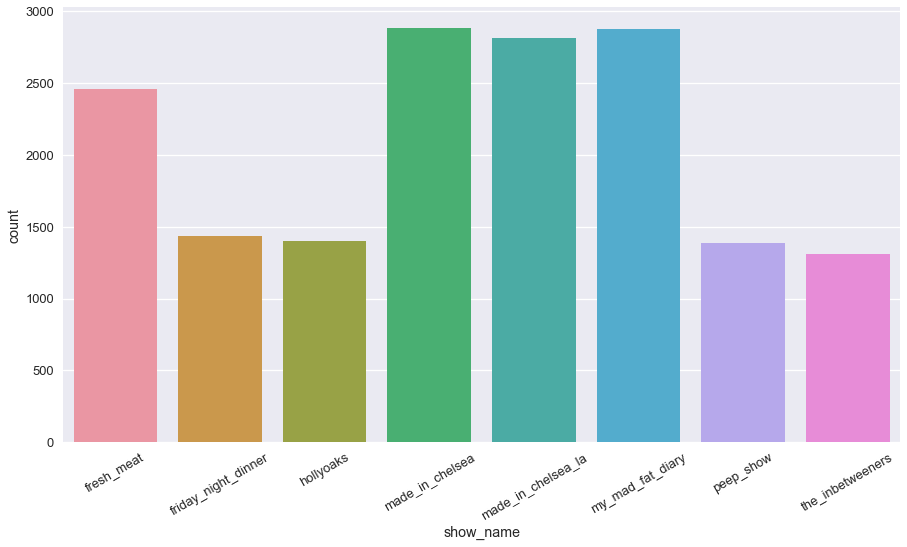

In [35]:
plt.figure( figsize = (15, 8))
sns.set(style = 'darkgrid', context = 'talk')
g = sns.countplot( 
            x = 'show_name',
            data = data
        )

g.set_xticklabels(rotation = 30, labels = g.get_xticklabels())
#g.set_title('')
#g.legend(loc='upper right')

There are 4 output labels.

-----
Data points by output labels
-----
h_alcohol_str      3301
h_food_str         1464
h_hot_drink_str     679
h_phone_str         948
dtype: int64


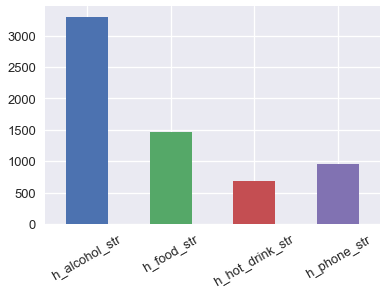

In [48]:
l_output_lables = [ col for col in data.columns if ('h_' in col and '_str' in col)]
print(f'There are {len(l_output_lables)} output labels.\n\n-----\nData points by output labels\n-----')
data_outputcount = data[l_output_lables].sum()
print(data_outputcount)
data_outputcount.plot.bar(rot=30)

### B. Training the Model
* model selection is easy with the help of this [sk-learn flowchat](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* looks like our model of choice is **SVC**
* Since the problem only required us to predict a **single Output label**, I will pick `h_phone_str`

#### Preliminary
let's load the required libraries

In [2]:
#Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Algorithms: Import your model of choice here! Or comment out what you don't need

# Supervised ML Models
from sklearn.svm import SVC, NuSVC, LinearSVC

# Model Evaluation
from sklearn.model_selection import cross_val_score                           # Prevent Overfitting
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score  # classification

# Hyper-parameters tuning
from sklearn.model_selection import GridSearchCV

#### Train Test Split
let's create training and testing data

In [53]:
l_features_col = [col for col in data.columns if 'r_' in col]

X_train, X_test, y_train, y_test = train_test_split(
        data[l_features_col],
        data['h_phone_str'],
        test_size = 0.3,
        random_state = 420
    )

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (11597, 1604)
X_test shape: (4971, 1604)


#### Training the Model

In [91]:
s_time = time.clock()
model = SVC( kernel = 'poly',
            gamma = 10,
            C = 1,
            degree = 3,
            probability= True
           )
model.fit(X_train, y_train)
e_time = time.clock()

print(f'Trained model in {"{:2f}".format(e_time - s_time)} s.')

Trained model in 3187.281836 s.


#### Evaluate the model

In [87]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'Trained score: {train_score}, Test score: {test_score}')

Trained score: 0.9789600758816935, Test score: 0.9301951317642325


In [88]:
y_predict = model.predict(X_test)
conf_mat = confusion_matrix( y_test, y_predict)
tn, fp, fn, tp = conf_mat.ravel()

conf_mat_score_dict = {}
conf_mat_score_dict['accuracy'] = (tn + tp)/ (tn+ fp+ fn+ tp)
conf_mat_score_dict['precision'] = tp/ (fp + tp)
conf_mat_score_dict['recall'] = tp/ (tp + fn)
conf_mat_score_dict['f1'] = 2 * (conf_mat_score_dict['precision'] * conf_mat_score_dict['recall'])/ (conf_mat_score_dict['precision'] + conf_mat_score_dict['recall'])

for key in conf_mat_score_dict:
    print(f'{key}: {"{:.2%}".format(conf_mat_score_dict[key])}')

conf_mat = pd.DataFrame(data = conf_mat, 
                        index = [['actual','actual'],[0,1]], 
                        columns = [['predicted','predicted'],[0,1]]
                                   )

print(f'-----\nConfusion Matrix\n-----')
conf_mat

accuracy: 93.02%
precision: 30.63%
recall: 26.05%
f1: 28.16%
-----
Confusion Matrix
-----


predicted     
                 0    1
actual 0      4556  154
       1       193   68

#### ROC Curve and AUC

Aera under the curve: 0.71


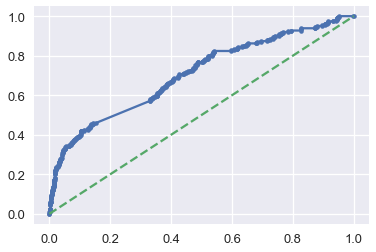

In [93]:
y_pred_prob = model.predict_proba(X_test)[:,1]
auc = roc_auc_score( y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve( y_test, y_pred_prob)
print(f'Aera under the curve: {"{:.2f}".format(auc)}')
plt.plot( fpr, tpr, marker = '.')
plt.plot( [0,1],[0,1], linestyle = '--')